## SES synthesis image processing example

## Create mean image of last 10 images

Text(0.5, 1.0, 'Mean of last 10 images')

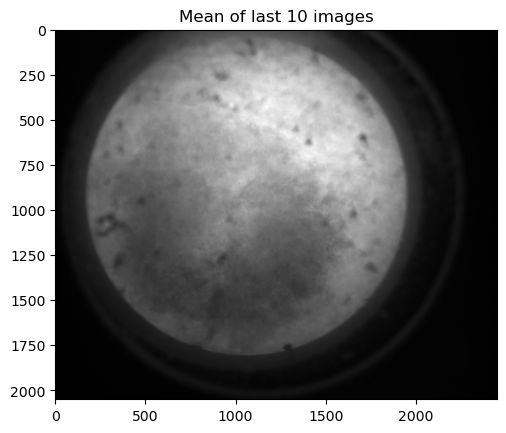

In [415]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
from skimage import measure

#import the files names
im_path='/Users/cdurkin/Projects/SES_synthesis/SES_Pulse_71/SES_Pulse_71_test_set'
files= glob.glob(os.path.join(im_path,'*.jpg'))

#calculate the mean of the previous ten images
files=np.sort(files)
photo_mean=None
count=0
#for this notebook, just need to choose the test image.  Here it is image number 51 in the list
file_count=51
while count < 10:
    file_count=file_count-1
    photo=cv2.imread(files[file_count])
    photo_hsv=cv2.cvtColor(photo,cv2.COLOR_BGR2HSV)
    photo_value=photo_hsv[:,:,2]
    photo_value=cv2.normalize(photo_value,None,0, 255,cv2.NORM_MINMAX)
    if np.array(photo_mean).any() == None:
        photo_mean=photo_value/10
    else:
        photo_mean=photo_mean + photo_value/10
    count=count+1
photo_mean=photo_mean.astype(int)
plt.figure()
plt.imshow(photo_mean,cmap=plt.cm.gray)
plt.title('Mean of last 10 images')

### Import the image of interest and convert to greyscale (actually the "value")

Text(0.5, 1.0, 'Example image to process, gray value')

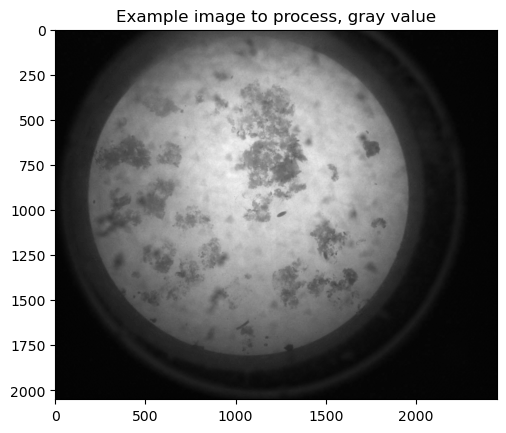

In [385]:
photo1=cv2.imread(files[51])
photo1_hsv=cv2.cvtColor(photo1,cv2.COLOR_BGR2HSV)
#HSV = Hue, Saturation, Value.  We are using the value which is basically greyscale
photo1_value=photo1_hsv[:,:,2]
plt.figure()
plt.imshow(photo1_value,cmap=plt.cm.gray)
plt.title('Example image to process, gray value')

### Subtract the 10-image mean from the image of interest

Text(0.5, 1.0, 'Image with background noise and scratches removed')

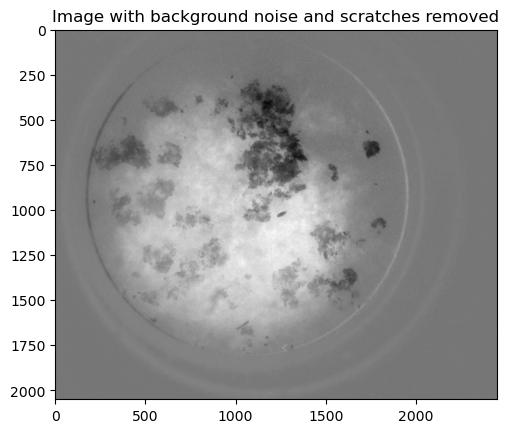

In [386]:
photo1_norm=cv2.normalize(photo1_value,None,0, 255,cv2.NORM_MINMAX)
photo_denoise1=photo1_norm-photo_mean
if np.min(photo_denoise1)<0:
    photo_denoise=photo_denoise1+abs(np.min(photo_denoise1))
else:
    photo_denoise=photo_denoise1.copy()
#photo_denoise=cv2.convertScaleAbs(photo_denoise)
photo_denoise=cv2.normalize(photo_denoise,None,0, 255,cv2.NORM_MINMAX)
plt.figure()
plt.imshow(photo_denoise,cmap=plt.cm.gray)
plt.title('Image with background noise and scratches removed')



## Need to normalize the variation in brightness in the background, this also makes it look like the original image again.

Text(0.5, 1.0, 'Background removed image of interest')

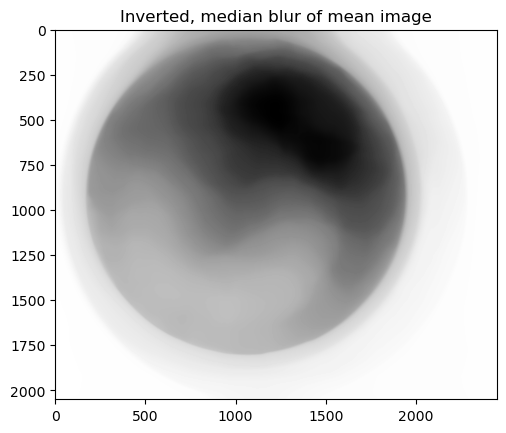

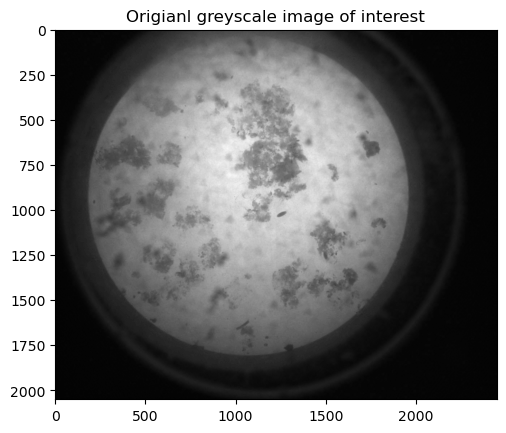

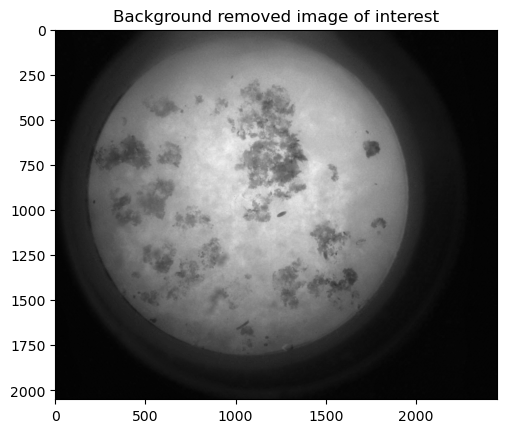

In [418]:
#This is a median blur of the mean image, and inverted
photo_blur=cv2.medianBlur(cv2.convertScaleAbs(photo_mean),251)
photo_blur=abs(photo_blur.astype(int)-255)
plt.figure()
plt.imshow(photo_blur,cmap=plt.cm.gray)
plt.title("Inverted, median blur of mean image")

#Create an image with no background
photo_nobg=photo_denoise-photo_blur
if np.min(photo_nobg)<0:
    photo_nobg=photo_nobg+abs(np.min(photo_nobg))


plt.figure()
plt.imshow(photo1_value.astype(int),cmap=plt.cm.gray)
plt.title('Origianl greyscale image of interest')
photo_nobg=cv2.normalize(photo_nobg,None,0, 255,cv2.NORM_MINMAX)
plt.figure()
plt.imshow(photo_nobg.astype(int),cmap=plt.cm.gray)
plt.title('Background removed image of interest')


### Need to mask out the circle edges

Text(0.5, 1.0, 'automatic circle fitting to largest object in above image')

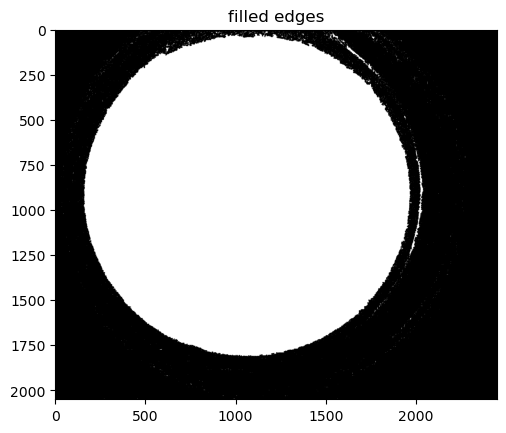

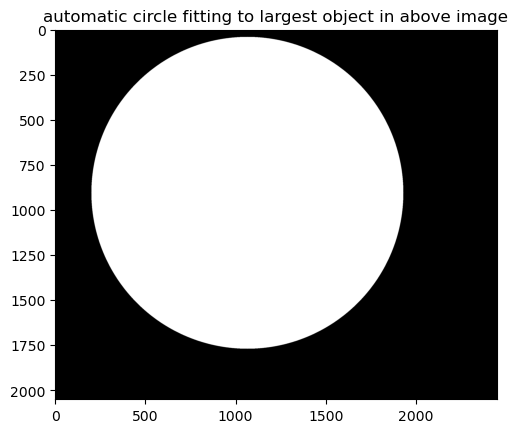

In [419]:
circle_markers=np.zeros_like(photo_mean)

#Find the edges in the blurred image
circle_markers=cv2.Canny(cv2.convertScaleAbs(photo_blur),6,6)
##Also use the edges in the mean image.
circle_markers3=cv2.Canny(cv2.convertScaleAbs(photo_mean),10,10)
circle_markers[circle_markers3==255]=255
#To help connect the circle, mask out the darkest pixels in the blured image too
circle_markers[photo_blur<np.mean(photo_blur[500:1500,500:1500])]=255

#Close the circle
kernel = np.ones((5, 5), np.uint8)
circle_marker_dilation=cv2.dilate(circle_markers,kernel,1)  
contours, hierarchy = cv2.findContours(circle_marker_dilation, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
circle_markers2=np.zeros_like(circle_markers)
for cnt in contours:
    cv2.drawContours(circle_markers2,[cnt],-1,255,-1)
circle_markers2=cv2.erode(circle_markers2,kernel,1)  

plt.figure()
plt.imshow(circle_markers2,cmap=plt.cm.gray)
plt.title('filled edges')

#Now have it find the circle for the largest object
contours,_= cv2.findContours(cv2.convertScaleAbs(circle_markers2), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(c) for c in contours]
sorted_areas = np.sort(areas)
cnt=contours[areas.index(sorted_areas[-1])] 
(x,y),radius = cv2.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius = int(radius)-50
plt.figure()
mask=np.zeros_like(photo_nobg)
cv2.circle(mask,center,radius,(255),-1)
plt.imshow(mask,cmap=plt.cm.gray)
plt.title('automatic circle fitting to largest object in above image')

## Now use various thresholding and edge detection approaches to detect the particles

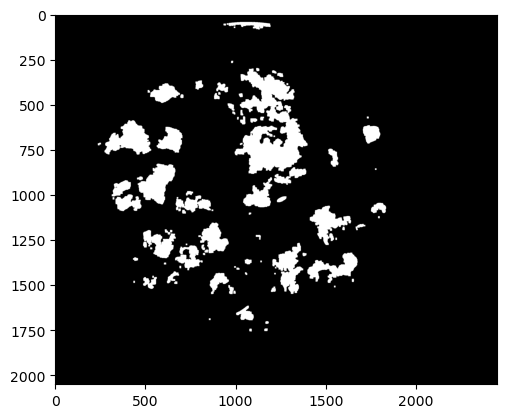

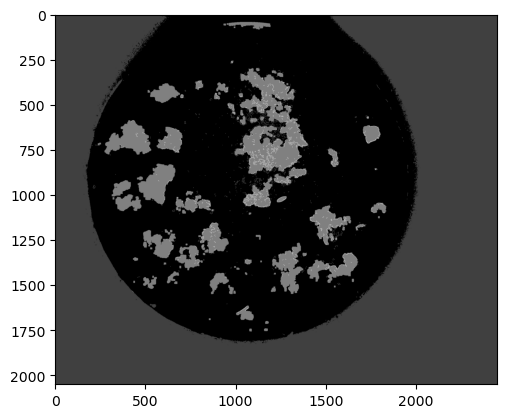

In [410]:
#Use adaptive thesholding to find potential particles
markers=cv2.adaptiveThreshold(cv2.convertScaleAbs(photo_nobg), 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 801, 3)

#Also find the very darkest pixels to help close some of the gaps in the adaptive threshold. Label those dark pixels=50
dark_markers=np.zeros_like(markers)
dark_markers[photo_nobg<0.4*np.median(photo_mean[mask==255])]=50

#Add those dark pixels into the adaptive thesholded pixels and label them all value=255
markers[dark_markers==50]=255
markers[mask==0]=0

#Get rid of smallest particle noise
kernel = np.ones((5, 5), np.uint8)   
marker_erosion=cv2.erode(markers,kernel,1)  
marker_erosion=cv2.erode(marker_erosion,kernel,1)  
marker_dilation=cv2.dilate(marker_erosion,kernel,1)  
marker_dilation=cv2.dilate(marker_dilation,kernel,1)  

#Fill in the shapes and label them with value=100
contours, hierarchy = cv2.findContours(marker_dilation, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
markers2=np.zeros_like(markers)
for cnt in contours:
    cv2.drawContours(markers2,[cnt],-1,100,-1)
#Identify edges and label them with value = 50
edges=cv2.Canny(cv2.convertScaleAbs(photo_nobg),50,80)
edges[edges==255]=100

#Sum together the markers, dark pixels, and edges so that each particle has values ranging between 50 and 200, depending on how it was detected
combined=markers2+edges+dark_markers
plt.figure()
plt.imshow(markers2,cmap=plt.cm.gray)
plt.figure()
plt.imshow(combined,cmap=plt.cm.gray)


### Reduce noise.  All particles must have atleast partially been detected by the adaptive threshold (value=100) and also either partially detected with the dark pixel theshold (+50) and/or the sharp edge detection (+50).  So the particle must have atleast one pixel with a value of 150 or greater

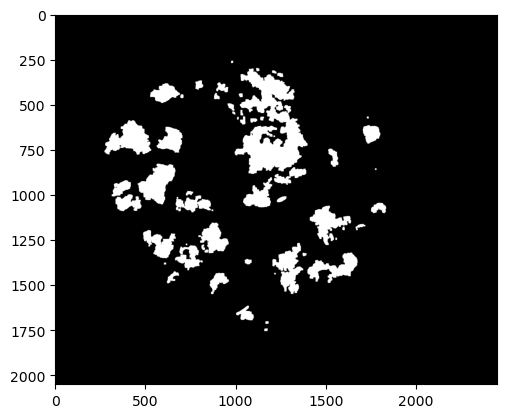

In [411]:
num_labels, label_image = cv2.connectedComponents(markers2)
sharp_particles=[]
sharp_img=np.zeros_like(label_image)
for n in np.arange(1,num_labels):
    pixels=combined[label_image==n]
    if len(pixels[pixels>=150])/len(pixels)>0:
        sharp_particles.append(n)
        sharp_img[label_image==n]=255
            
detected_img=sharp_img.astype('ubyte')
label_image_detect = cv2.connectedComponentsWithStats(detected_img)
plt.figure()
plt.imshow(detected_img,cmap=plt.cm.gray)

### Create an example image that outlines what was detected

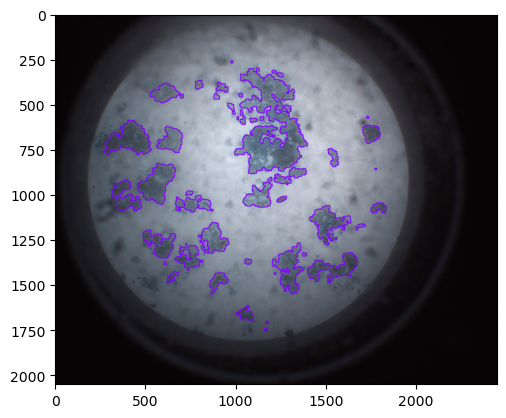

In [412]:
particle_edges=cv2.Canny(detected_img,100,200,5)
kernel = np.ones((5, 5), np.uint8)
edge_dilation=cv2.dilate(particle_edges,kernel,1)  

example_img=photo1.copy()
example_img[edge_dilation==255]=[127,0,255]
plt.figure()
plt.imshow(example_img)


### Measure particles

In [416]:

properties = measure.regionprops(label_image_detect[1])

count=0
particle_area = []
particle_ESD = []
particle_perimeter = []
particle_major_axis= []
particle_minor_axis= []
particle_numberID = []
file_name = []
bounding_box = []
scale= (0.07194)
scale_area = scale**2 
file='test'
for x in properties:
        count = count +1
        px_area=x.area
        um_area = px_area / scale_area
        min_axis = x.minor_axis_length / scale
        maj_axis = x.major_axis_length / scale
        perim = x.perimeter / scale
        ESD = 2*(np.sqrt(um_area/np.pi))
        particle_perimeter.append(perim)
        particle_major_axis.append(maj_axis)
        particle_minor_axis.append(min_axis)
        particle_area.append(um_area)
        particle_ESD.append(ESD)
        particle_numberID.append(count)
        file_name.append(file)
        bounding_box.append(str([x.bbox[0],x.bbox[2],x.bbox[1],x.bbox[3]]))

#Input all data into a dataframe.#
data = pd.DataFrame(np.stack((particle_numberID, particle_area, particle_ESD, particle_minor_axis, particle_major_axis, particle_perimeter, file_name, bounding_box),-1),columns=['Number','Area','ESD','minor_length','major_length','perimeter','file_name', 'bounding_box'])






    

In [417]:
data

,Number,Area,ESD,minor_length,major_length,perimeter,file_name,bounding_box
0,1,28403.801425662146,190.1705634317731,177.00875755882387,208.36327607304887,606.850906998782,test,"[259, 272, 975, 987]"
1,2,56034.71029552396,267.10598837547553,249.76389337048798,291.9414584112747,880.0904712119092,test,"[299, 317, 1114, 1132]"
2,3,21432310.572343167,5223.836268084293,4801.733129218034,8802.407751396162,67069.78536193352,test,"[302, 886, 995, 1399]"
3,4,66082.31352092826,290.06656957056083,218.4408517514161,394.68979931976094,1033.9835461613877,test,"[312, 330, 1202, 1227]"
4,5,119218.67673220098,389.6074096913919,308.0783867906199,507.7987234598532,1403.5385425142777,test,"[326, 349, 1231, 1264]"
5,6,312828.2619601838,631.1143429193133,591.1279558169108,717.4085028387728,2488.354091031689,test,"[368, 419, 778, 821]"
6,7,434172.39322083566,743.5088837943182,656.8954277184858,1007.7632306798957,3877.5829692212124,test,"[379, 434, 893, 959]"
7,8,2023819.1573631654,1605.2434651937933,1300.8768995056316,2088.961279642948,7174.140224330341,test,"[384, 493, 527, 692]"
8,9,147622.47815786314,433.54212815180273,402.78409845556456,525.7234086408419,1644.2072733870154,test,"[438, 472, 881, 912]"
9,10,78641.81755268363,316.43304501572624,300.1957755894271,343.0551550897259,1061.7844913935257,test,"[439, 461, 1018, 1040]"
